## Import needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, cv
from sentence_transformers import SentenceTransformer, SparseEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SEED = 123
K_FOLDS = 5

## Import train and/or test data

In [2]:
CLEAN_DATA_PATH = 'pfacouetey/DSTI_Deep_Learning_Project_2025' # Data path to get clean datasets

TRAIN_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/train.feather' # Train data path
TEST_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/test.feather' # Test data path

In [3]:
train_df = pd.read_feather(TRAIN_DATA_PATH)
test_df = pd.read_feather(TEST_DATA_PATH)

'(ReadTimeoutError("HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c8a712a7-20dc-4410-854b-c173b265a4ec)')' thrown while requesting GET https://huggingface.co/datasets/pfacouetey/DSTI_Deep_Learning_Project_2025/resolve/main/train.feather
Retrying in 1s [Retry 1/5].


In [4]:
train_df.shape[0], test_df.shape[0]

(64000, 16000)

In [5]:
train_df.head()

,text,label
0,sub for alcoholics over 30 or 40? i am looking...,alcoholism
1,i’m sick of lashing out i know that a huge par...,bpd
2,"seeking advice hello all, i do not know if thi...",bpd
3,confused and lost? minor tw// i briefly mentio...,ptsd
4,my brain is so foggy and i’m so exhausted the ...,EDAnonymous


In [6]:
train_df['label'].value_counts(normalize=True)

label
adhd             0.063641
healthanxiety    0.062828
bipolarreddit    0.062750
socialanxiety    0.062687
bpd              0.062641
normal           0.062578
autism           0.062516
ptsd             0.062500
suicidewatch     0.062484
depression       0.062484
alcoholism       0.062484
anxiety          0.062437
lonely           0.062141
EDAnonymous      0.062047
schizophrenia    0.062031
addiction        0.061750
Name: proportion, dtype: float64

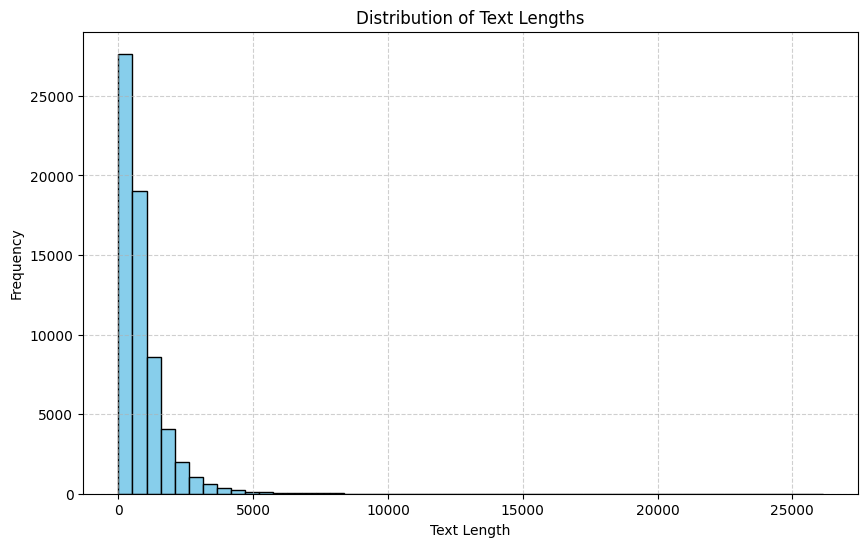

In [7]:
# Distribution of the text_length in column 'text'
train_df['text_length'] = train_df['text'].str.len
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
train_df['text_length'].describe()

count    64000.000000
mean       867.295422
std        890.821481
min          4.000000
25%        322.000000
50%        616.000000
75%       1108.000000
max      26134.000000
Name: text_length, dtype: float64

Quite short to very long paragraphs are among the texts.

## Text engineering

- Before imputing this text as input into any classical ML model, we need to vectorize it into numerical features that can describe it.
- We use the python framework [SentenceTransformers](https://www.sbert.net/) which maps sentences & paragraphs to a fixed dimensional vector space. There's two ways mentionned in its documentation to compute embeddings, and both are quite interesting to use :
    - A dense numerical representation in a 384 dimensional space.
    - A sparse numerical representation up to a 30522 dimensional space.
- For dense representation, we use the ['all-MiniLM-L6-v2' model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), whereas for sparse encodings we use the ['opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini' model](https://huggingface.co/opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini). They are some default pretrained models which offer quite good and quick results, and are also easy to load without requirements of any identification.
- We will use a 384 dimensional space for both dense and sparse encodings.

In [9]:
MAX_DIM = 384
dense_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sparse_model = SparseEncoder("opensearch-project/opensearch-neural-sparse-encoding-doc-v2-mini")

In [ ]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time
try:
    dense_train_encodings_df = pd.DataFrame(data=np.loadtxt(fname='dense_train_encodings.txt'))
except FileNotFoundError:
    dense_train_encodings_df = dense_model.encode(sentences=train_df['text'], truncate_dim=MAX_DIM, show_progress_bar=True)
    np.savetxt(fname='dense_train_encodings.txt', X=dense_train_encodings_df)
    dense_train_encodings_df = pd.DataFrame(dense_train_encodings_df)    

assert dense_train_encodings_df.shape[1] == MAX_DIM

dense_train_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.010115,-0.071940,-0.000676,0.046509,0.011784,0.024228,-0.016724,-0.023111,-0.028462,-0.032814,...,0.006937,0.000356,-0.013221,0.072090,0.000962,-0.078869,0.166801,0.020069,0.011311,-0.063025
1,0.028721,-0.035522,0.033274,0.064982,0.035427,0.073292,0.002315,0.008044,0.018241,-0.070199,...,-0.002490,0.008170,-0.032828,0.011647,-0.047595,0.048076,0.037094,-0.009942,-0.055980,0.048011
2,-0.023629,0.002767,0.048422,-0.015943,0.030141,0.009815,0.039722,0.062591,0.085358,-0.064029,...,0.053965,-0.032141,-0.000480,0.168467,-0.066945,0.114125,-0.051470,-0.054581,-0.048716,-0.033569
3,0.016562,-0.028279,0.070951,0.081466,0.130234,0.048159,-0.005776,0.019353,0.033980,-0.056824,...,0.018988,0.049933,-0.002120,0.090303,0.009652,0.008848,0.041280,-0.018405,-0.097029,0.065968
4,0.046098,-0.055147,0.105932,0.075826,0.027693,0.006238,0.053123,-0.013525,0.031125,0.003701,...,-0.004607,0.015182,-0.055888,0.060600,-0.137230,-0.009460,0.088326,0.084787,-0.072384,-0.008418


In [11]:
dense_train_encodings_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,...,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,0.017940,-0.027953,0.020131,0.039742,0.035896,0.008196,0.022718,0.020104,0.016265,-0.052602,...,0.005369,0.022633,-0.011754,0.045337,-0.023845,0.005875,0.036061,0.007675,-0.055744,0.004595
std,0.047479,0.049040,0.041975,0.044394,0.047086,0.044808,0.046185,0.044062,0.051769,0.047757,...,0.042781,0.042683,0.039676,0.050338,0.049992,0.045998,0.050869,0.049391,0.052361,0.039453
min,-0.194135,-0.229354,-0.157077,-0.163909,-0.175774,-0.178978,-0.156196,-0.180479,-0.200895,-0.234702,...,-0.167967,-0.157618,-0.174101,-0.152743,-0.247863,-0.203440,-0.166523,-0.204288,-0.296280,-0.161933
25%,-0.012693,-0.061371,-0.008112,0.010773,0.004983,-0.021652,-0.008701,-0.009418,-0.018051,-0.085685,...,-0.024206,-0.004925,-0.038330,0.010809,-0.057976,-0.024129,0.002057,-0.025576,-0.091414,-0.021830
50%,0.019778,-0.028973,0.019757,0.041599,0.038450,0.009180,0.021348,0.020353,0.016563,-0.054522,...,0.004041,0.024506,-0.012445,0.044346,-0.025130,0.008287,0.036741,0.007128,-0.056737,0.003971
75%,0.050564,0.004430,0.048265,0.070727,0.068913,0.039096,0.052569,0.049617,0.051209,-0.021212,...,0.033538,0.052054,0.014449,0.078746,0.009609,0.038033,0.070646,0.040728,-0.021071,0.030882
max,0.190847,0.183068,0.208253,0.210602,0.225933,0.218833,0.252473,0.212958,0.217027,0.147851,...,0.198835,0.184642,0.171796,0.257274,0.200068,0.191616,0.249901,0.253075,0.168540,0.183448


In [ ]:
# Run embeddings' computation once, save results so next time only loadings will be done
# First time runing it always taking some time
try:
    sparse_train_encodings_df = pd.DataFrame(data=np.loadtxt(fname='sparse_train_encodings.txt'))
except FileNotFoundError:
    sparse_train_encodings_df = sparse_model.encode_document(sentences=train_df['text'], show_progress_bar=True).to_dense().numpy()
    sparse_train_encodings_df = pd.DataFrame(data=sparse_train_encodings_df)   
    # Remove columns where all values are 0
    sparse_train_encodings_df = sparse_train_encodings_df.loc[:, ~(sparse_train_encodings_df == 0).all(axis=0)]
    # Keep only MAX_DIM
    sparse_train_encodings_df = (sparse_train_encodings_df.T[0:MAX_DIM]).T
    np.savetxt(fname='sparse_train_encodings.txt', X=sparse_train_encodings_df.values)

assert sparse_train_encodings_df.shape[1] <= MAX_DIM

sparse_train_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
sparse_train_encodings_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
count,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,64000.000000,6.400000e+04,...,6.400000e+04,6.400000e+04,64000.000000,6.400000e+04,6.400000e+04,6.400000e+04,6.400000e+04,64000.000000,6.400000e+04,6.400000e+04
mean,1.783714e-07,3.878625e-08,2.917045e-07,7.745291e-08,6.762805e-08,3.222822e-07,1.788844e-08,2.339863e-08,0.000001,9.812665e-09,...,6.902369e-09,5.362129e-07,0.000003,8.863977e-08,1.999536e-08,6.624344e-08,2.810420e-09,0.000003,3.308172e-07,2.924778e-09
std,2.925858e-05,9.812232e-06,5.241849e-05,1.410330e-05,1.388925e-05,5.034055e-05,4.525456e-06,5.919437e-06,0.000067,2.482430e-06,...,1.746176e-06,6.375296e-05,0.000216,1.752150e-05,5.058469e-06,9.929434e-06,7.109864e-07,0.000165,6.274289e-05,7.399167e-07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
max,6.053722e-03,2.482320e-03,1.258365e-02,2.949728e-03,3.384708e-03,1.114993e-02,1.144860e-03,1.497512e-03,0.008707,6.280105e-04,...,4.417516e-04,1.310818e-02,0.025836,4.310311e-03,1.279703e-03,2.040551e-03,1.798669e-04,0.016502,1.431555e-02,1.871858e-04


Although decision trees can perform some features' selection to identify best splitter at each node, our current number of features (2*387) is quite high. Let's try some reduction techniques like PCA to get combinations which capture main variances.

## Perform reduction on embeddings

Let's do a quickly analysis of embeddings' variance.

In [14]:
dense_train_encodings_df.var(skipna=False).describe()

count    3.840000e+02
mean     2.132089e-03
std      4.376324e-04
min      9.557233e-66
25%      1.895247e-03
50%      2.130166e-03
75%      2.390562e-03
max      3.482291e-03
dtype: float64

In [15]:
sparse_train_encodings_df.var(skipna=False).describe()

count    3.840000e+02
mean     7.275582e-06
std      1.410139e-04
min      1.697583e-15
25%      8.228470e-11
50%      7.023388e-10
75%      2.400370e-09
max      2.763285e-03
dtype: float64

Before applying any reduction technique, we could remove some embeddings would be quite beneficial since their variance isn't really much :
- For dense embeddings, 25% have quite null variance.
- Whereas 75% of spare encodings have null variance.

In [16]:
variance_threshold = 1.895247e-03 # We choose arbitrarly this threshold based on dense_train_encodings_df columns variances description

dense_train_encodings_df = dense_train_encodings_df.loc[:, dense_train_encodings_df.var() >= variance_threshold]
sparse_train_encodings_df = sparse_train_encodings_df.loc[:, sparse_train_encodings_df.var() >= variance_threshold]

dense_train_encodings_df.shape, sparse_train_encodings_df.shape

((64000, 288), (64000, 1))

We still keep 288/387 columns for dense embeddings, but only one remains for sparse encodings.

In [17]:
dense_train_encodings_df.var(skipna=False).describe()

count    288.000000
mean       0.002303
std        0.000311
min        0.001896
25%        0.002080
50%        0.002229
75%        0.002462
max        0.003482
dtype: float64

In [18]:
sparse_train_encodings_df.var(skipna=False).describe() # Only one colummn

count    1.000000
mean     0.002763
std           NaN
min      0.002763
25%      0.002763
50%      0.002763
75%      0.002763
max      0.002763
dtype: float64

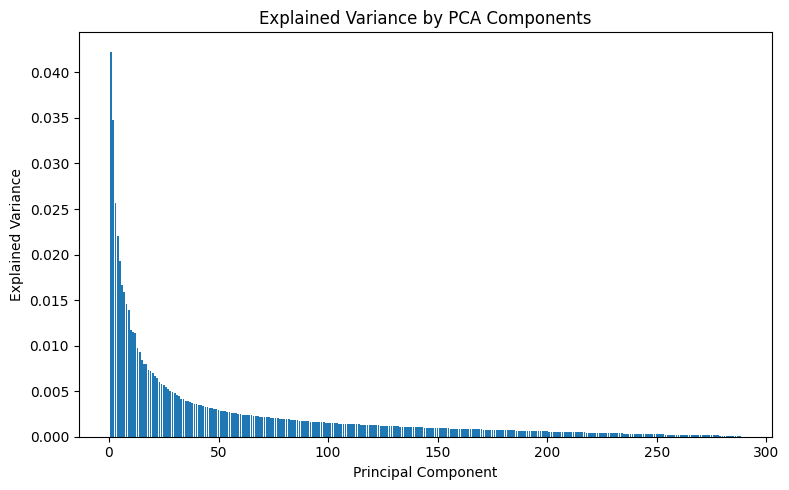

In [19]:
pca = PCA(n_components=None)
pca.fit(dense_train_encodings_df)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.tight_layout()
plt.show()

In [20]:
pca.explained_variance_[0:30] # We keep only the first 12 components, each explaining at least 1% of the initial variance

array([0.04228752, 0.03480313, 0.02570125, 0.02206292, 0.01926693,
       0.01663875, 0.0158758 , 0.01452607, 0.0138698 , 0.01173478,
       0.01149005, 0.0113689 , 0.0097459 , 0.0093122 , 0.00843262,
       0.00802321, 0.00795945, 0.00732097, 0.00718376, 0.00699223,
       0.00670541, 0.00646819, 0.00605641, 0.00583698, 0.00565485,
       0.0054901 , 0.00529041, 0.00505406, 0.00486251, 0.00475197])

In [21]:
pca = PCA(n_components=12)
pca.fit(dense_train_encodings_df)

final_dense_train_encodings_df = pd.DataFrame(data=pca.fit_transform(dense_train_encodings_df))

final_dense_train_encodings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.258492,-0.181575,-0.286161,-0.044860,-0.223887,0.028291,0.266374,-0.017262,0.124097,-0.017408,-0.051520,0.254182
1,0.108375,0.026074,0.125640,-0.006708,-0.034151,0.001346,0.053640,0.028346,0.081232,-0.172618,0.102065,-0.150160
2,0.221538,-0.232088,-0.073474,-0.164689,0.039122,-0.177982,-0.006273,0.086229,0.007722,0.093571,0.039712,-0.160120
3,0.295485,-0.025807,0.089074,-0.136574,0.198419,-0.042420,0.116728,-0.018210,0.160342,0.078404,-0.012544,0.083571
4,-0.165489,0.111261,0.016620,0.142141,-0.013769,0.058417,-0.155747,0.008402,0.136622,0.152597,0.028557,-0.046187


In [22]:
final_sparse_train_encodings_df = sparse_train_encodings_df.copy()

final_sparse_train_encodings_df.head()

,46
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [23]:
X_train = pd.concat([final_dense_train_encodings_df, final_sparse_train_encodings_df], axis=1)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,46
0,-0.258492,-0.181575,-0.286161,-0.044860,-0.223887,0.028291,0.266374,-0.017262,0.124097,-0.017408,-0.051520,0.254182,0.0
1,0.108375,0.026074,0.125640,-0.006708,-0.034151,0.001346,0.053640,0.028346,0.081232,-0.172618,0.102065,-0.150160,0.0
2,0.221538,-0.232088,-0.073474,-0.164689,0.039122,-0.177982,-0.006273,0.086229,0.007722,0.093571,0.039712,-0.160120,0.0
3,0.295485,-0.025807,0.089074,-0.136574,0.198419,-0.042420,0.116728,-0.018210,0.160342,0.078404,-0.012544,0.083571,0.0
4,-0.165489,0.111261,0.016620,0.142141,-0.013769,0.058417,-0.155747,0.008402,0.136622,0.152597,0.028557,-0.046187,0.0


In [24]:
y_train = train_df['label']

y_train.head()

0     alcoholism
1            bpd
2            bpd
3           ptsd
4    EDAnonymous
Name: label, dtype: category
Categories (16, object): ['EDAnonymous', 'addiction', 'adhd', 'alcoholism', ..., 'ptsd', 'schizophrenia',
                          'socialanxiety', 'suicidewatch']

Later, the reproduced pipeline to use for the test set will be to compute its dense embeddings and reduce them to keep the first 12 components. As for its sparse embeddings, we just need to keep the one at the position 46 after computing them.

## Train a CatBoost classifier on embeddings

We train a CatBoost classifier with basics hyperparameters and analyze its performance by cross-validation. Some adavantages of thsi model is that we do not need to encode the target in any way, and it doesn't need much tuning on its hyperparameters.

For any info on this model, your refer to this link [CatBoost](https://catboost.ai/docs/en/).

In [25]:
train_pool = Pool(X_train, y_train)

params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': None,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'random_seed': SEED,
    'verbose': True
}

cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=K_FOLDS,
    shuffle=True,
    partition_random_seed=SEED,
    verbose=True,
    plot=False
)

Training on fold [0/5]
0:	learn: 0.3626082	test: 0.3633169	best: 0.3633169 (0)	total: 262ms	remaining: 26s
1:	learn: 0.3838220	test: 0.3854142	best: 0.3854142 (1)	total: 399ms	remaining: 19.5s
2:	learn: 0.4188854	test: 0.4187554	best: 0.4187554 (2)	total: 529ms	remaining: 17.1s
3:	learn: 0.4508820	test: 0.4500664	best: 0.4500664 (3)	total: 655ms	remaining: 15.7s
4:	learn: 0.4676616	test: 0.4692746	best: 0.4692746 (4)	total: 779ms	remaining: 14.8s
5:	learn: 0.4827027	test: 0.4799719	best: 0.4799719 (5)	total: 902ms	remaining: 14.1s
6:	learn: 0.4995214	test: 0.4987116	best: 0.4987116 (6)	total: 1.02s	remaining: 13.6s
7:	learn: 0.5150118	test: 0.5126103	best: 0.5126103 (7)	total: 1.15s	remaining: 13.2s
8:	learn: 0.5235677	test: 0.5190130	best: 0.5190130 (8)	total: 1.27s	remaining: 12.8s
9:	learn: 0.5290567	test: 0.5256500	best: 0.5256500 (9)	total: 1.4s	remaining: 12.6s
10:	learn: 0.5337839	test: 0.5293199	best: 0.5293199 (10)	total: 1.53s	remaining: 12.4s
11:	learn: 0.5419882	test: 0.538

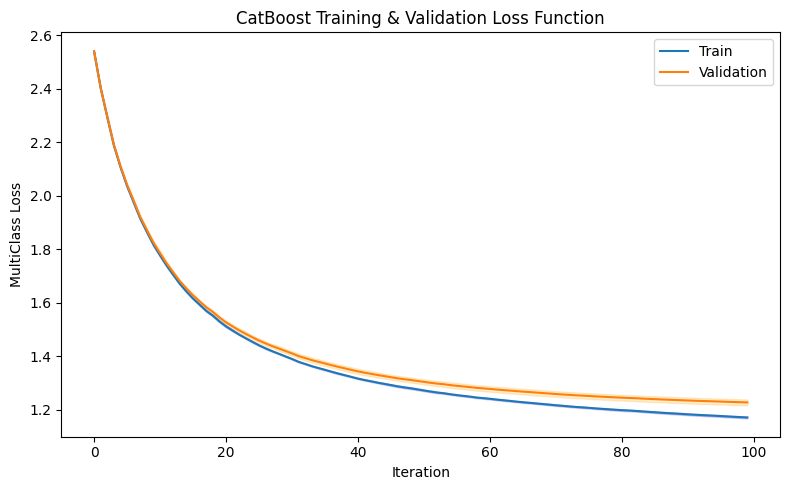

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(cv_results['train-MultiClass-mean'], label='Train')
plt.plot(cv_results['test-MultiClass-mean'], label='Validation')
plt.fill_between(
    range(len(cv_results)),
    cv_results['train-MultiClass-mean'] - cv_results['train-MultiClass-std'],
    cv_results['train-MultiClass-mean'] + cv_results['train-MultiClass-std'],
    alpha=0.2,
    color='blue'
)
plt.fill_between(
    range(len(cv_results)),
    cv_results['test-MultiClass-mean'] - cv_results['test-MultiClass-std'],
    cv_results['test-MultiClass-mean'] + cv_results['test-MultiClass-std'],
    alpha=0.2,
    color='orange'
)
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss Function')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
print('Monitoring loss function during training-validation :')
print(f" - During training : {np.mean(cv_results['train-MultiClass-mean'])} +/- {np.mean(cv_results['train-MultiClass-std'])}")
print(f" - During validation : {np.mean(cv_results['test-MultiClass-mean'])} +/- {np.mean(cv_results['test-MultiClass-std'])}")

Monitoring loss function during training-validation :
 - During training : 1.3923350512923107 +/- 0.0030391649663912344
 - During validation : 1.4229448502783015 +/- 0.009114889985534214


In [28]:
print('Monitoring accuracy during training-validation :')
print(f" - During training : {np.mean(cv_results['train-Accuracy-mean'])} +/- {np.mean(cv_results['train-Accuracy-std'])}")
print(f" - During validation : {np.mean(cv_results['test-Accuracy-mean'])} +/- {np.mean(cv_results['test-Accuracy-std'])}")

Monitoring accuracy during training-validation :
 - During training : 0.5917561268779395 +/- 0.0015069818110958857
 - During validation : 0.5824001303250612 +/- 0.00338811901974293


- The model's training didn't suffer from any overfitting case, and it's able to learn how to predict mental health state based on comments. 
- Let's retrain it using all the training set, then analyze mroe deeply its predictions.

In [ ]:
# Retrain CatBoost model on the whole training data
catboost_model = CatBoostClassifier(**params)
catboost_model.fit(X_train, y_train, verbose=10)

0:	learn: 0.3593438	total: 150ms	remaining: 14.8s
10:	learn: 0.5339531	total: 1.93s	remaining: 15.6s
20:	learn: 0.5744375	total: 4.63s	remaining: 17.4s
30:	learn: 0.5898750	total: 6.18s	remaining: 13.8s
40:	learn: 0.6013437	total: 7.64s	remaining: 11s
50:	learn: 0.6084063	total: 9.15s	remaining: 8.79s
60:	learn: 0.6140313	total: 10.8s	remaining: 6.9s
70:	learn: 0.6177344	total: 12.5s	remaining: 5.1s
80:	learn: 0.6215000	total: 14.1s	remaining: 3.31s
90:	learn: 0.6243125	total: 15.8s	remaining: 1.57s
99:	learn: 0.6265156	total: 17.2s	remaining: 0us


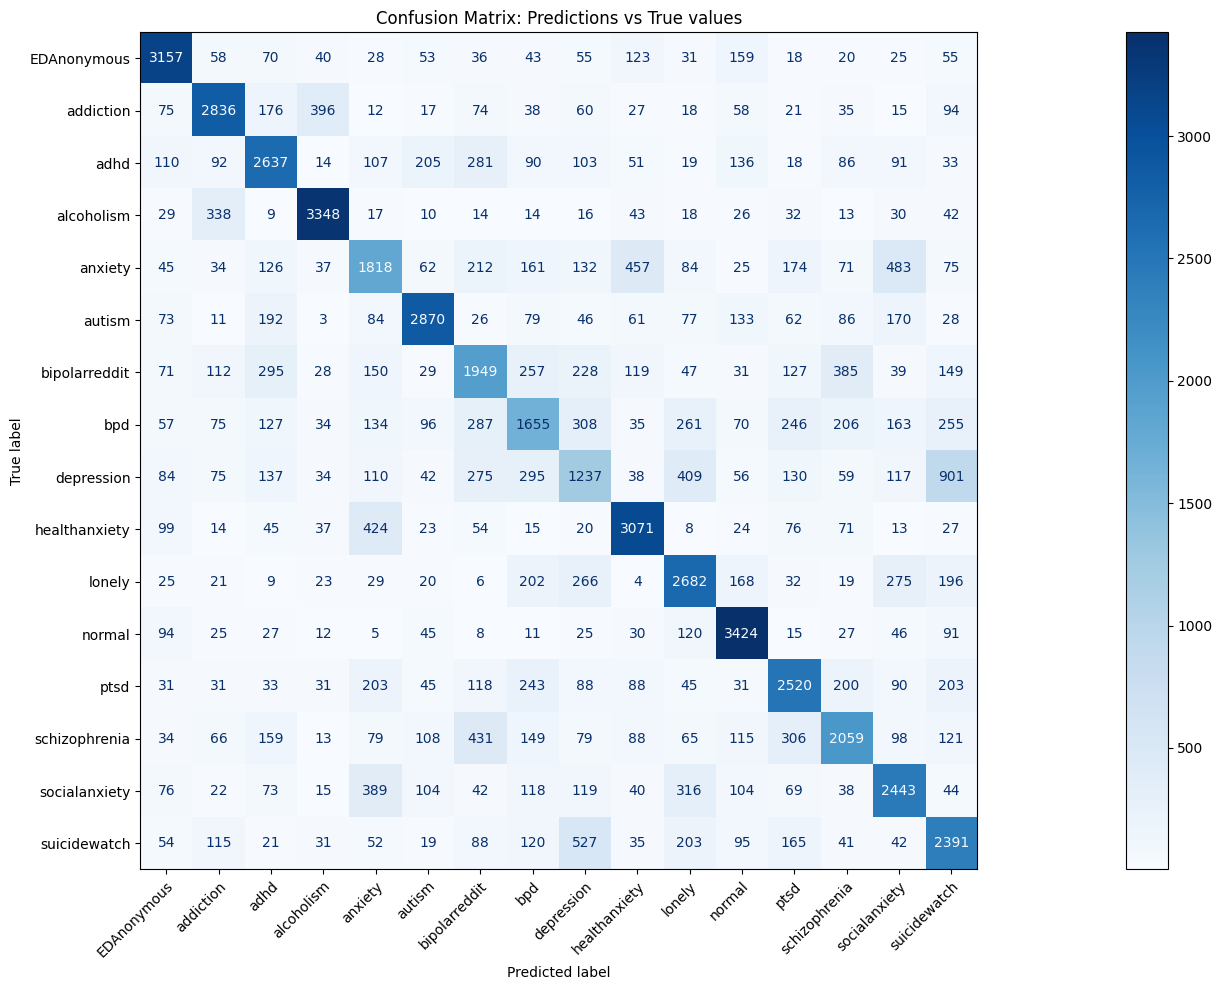

In [30]:
y_train_pred = catboost_model.predict(X_train)
class_names = list(y_train.cat.categories)

cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(30, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax) 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Confusion Matrix: Predictions vs True values")

plt.tight_layout()
plt.show()

Even though in general the model's accuracy seems really good, when anlyzing confusion matrix we could detect four mental health issues such as depression, bpd, bipolarreddit and anxiety where the number of true positives doesn't seem too dominant compared to their number of false negatives.